In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [87]:
env_name = 'CartPole-v0'
env = gym.make(env_name)


# Hard coded policy for the cartpole problem
# Will eventually want to build up infrastructure to develop a policy depending on:
# env.action_space
# env.observation_space

policy = nn.Sequential(
    nn.Linear(4, 12),
    nn.ReLU(),
    nn.Linear(12,12),
    nn.ReLU(),
    nn.Linear(12,2),
    nn.Softmax(dim=-1)
    )

optimizer = optim.Adam(policy.parameters(), lr = .00001)

# I guess we'll start with a categorical policy
# TODO investigate the cost of action.detach.numpy() and torch.Tensor(state)
def select_action(policy, state):
    m = Categorical(policy(torch.Tensor(state)))
    action = m.sample()
    logprob = m.log_prob(action)
    
    return action.detach().numpy(), logprob
    

In [86]:
policy(torch.randn(1,4))

tensor([[0., 1.]], grad_fn=<SoftmaxBackward>)

In [ ]:
#def vanilla_policy_grad(env, policy, optimizer):
    
action_list = []
state_list = []
logprob_list = []
reward_list = []

avg_reward_hist = []

num_epochs = 10000
#batch_size = 20 # how many steps we want to use before we update our gradients
num_steps = 1000 # number of steps in an episode (unless we terminate early)

loss = torch.zeros(1,requires_grad=True)

for epoch in range(num_epochs):

    # Probably just want to preallocate these with zeros, as either a tensor or an array
    loss_hist = []
    episode_length_hist = []
    action_list = []
    total_steps = 0

    while True:

        state = env.reset()
        logprob_list = []
        reward_list  = []
        action_list  = []
        
        for t in range(num_steps):

            action, logprob = select_action(policy, state)
            state, reward, done, _ = env.step(action.item())

            logprob_list.append(-logprob)
            reward_list.append(reward)
            action_list.append(action)
            total_steps += 1

            if done:
                break

        # Now Calculate cumulative rewards for each action
        episode_length_hist.append(t)
        episode_reward = torch.sum(torch.tensor(reward_list))
        logprob_t = torch.stack(logprob_list)
        
        loss = torch.sum(logprob_t)*episode_reward
        loss.backward()
        optimizer.step()
        
      #  episode_loss = torch.sum(
      #                  torch.stack(
      #                      [torch.sum(reward_ar[i:]*logprob_ar[i:]) for i in range(len(reward_list))]
      #      )
      #  )

        
        #if total_steps > batch_size:
        # update our gradients
        #print("here")
        avg_reward_hist.append(sum(episode_length_hist)/len(episode_length_hist))
        #other_list.append(1)
        #loss = torch.sum(torch.stack(loss_hist))
        #for action in episode_loss:
        #pisode_loss.backward()
        #optimizer.step()
        break


In [93]:
while True:
    state = env.reset()
    cum_rewards = 0


    for t in range(num_steps):
        action, _ = select_action(policy,state)
        state, reward, done, _ = env.step(action.item())
        env.render()
        
        cum_rewards += reward
        if done:
            
            print('summed reward for espide: ', cum_rewards)
            print('time terminated:' , t)
            break

summed reward for espide:  22.0
time terminated: 21
summed reward for espide:  30.0
time terminated: 29
summed reward for espide:  37.0
time terminated: 36
summed reward for espide:  35.0
time terminated: 34
summed reward for espide:  12.0
time terminated: 11
summed reward for espide:  25.0
time terminated: 24
summed reward for espide:  44.0
time terminated: 43
summed reward for espide:  42.0
time terminated: 41
summed reward for espide:  69.0
time terminated: 68
summed reward for espide:  38.0
time terminated: 37
summed reward for espide:  74.0
time terminated: 73
summed reward for espide:  25.0
time terminated: 24
summed reward for espide:  18.0
time terminated: 17
summed reward for espide:  38.0
time terminated: 37
summed reward for espide:  19.0
time terminated: 18


KeyboardInterrupt: 

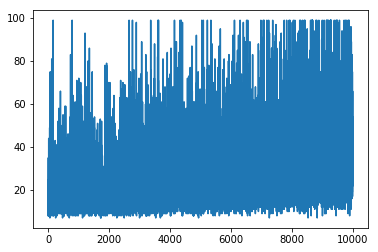

In [92]:
plt.plot(avg_reward_hist)